# **Overview**

This a movie recommendation project which I implemmented using the Alternating Least Square algorithm with the Apache Spark API to recommend movies for users based on their ratings of other movies.

# **Recommendation System** 

Recommendation systems are computer programs designed to provide recommendation of products and services for users based on their activities on a given website of online platform. These users activities are msot likely based on users previous pruchases, likes and ratings. The recommendation system make use of the earlier mentioned activities and possibly other activities as metrix to make pridictions of other products and services that would be of interest to users. Companies such as Amazon, Netflix etc make use of recommendation system to help users identify products and movies of interest for them. 

# **Types of Recommendation System**

There are three types of recommendation systems; content based filtering, collaborative filtering and hybrid filtering.

**Content Based Filtering**

In this type of recommendation system, the program finds the similarity between products based on its context or description. The program makes use of ther user’s previous history, searches for similar products the user may like and these similar products are receommended to the user.

**Collaborative Filtering**

This is the most sought after, most widely implemented and most mature technologies utilzed in the recommendation of products abd services for users available in the market. The recommendation works such that the users history is taken into account. Products purchased, rated and liked are some of the information utlized to make predictions for users of similar preferences.

**hybrid Filtering**

The hybrid filtering is a combination of the content based filtering and the collborative filtering recommendation system. 

In this project we'll make use of the collaborative filtering together with the altenating least squares (ALS) algorithm. Why use make of use ALS? 

# **Alternating Least Square (ALS)**

The ALS algorightm is based on matrix factorization technique where both runs in a parallel fashion. ALS is implemented in Apache Spark ML and built for a large-scale collaborative filtering problems. ALS is a robust and powerful algorithm used in solving scalability and sparseness of the Ratings data, and it’s simple and scales well to very large datasets.

# **Dataset**

The dataset used in this project is from the movielens dataset, sepcifically ml-latest-small. This dataset contains 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Users were selected at random for inclusion. All selected users had rated at least 1 movies. No demographic information is included. Each user is represented by an id, and no other information is provided. 

The data are contained in the files links.csv, movies.csv, ratings.csv and tags.csv.

This project is implemented in google colab, I had to start by installing pyspark, import the relevant libraries, config the spark session as required by apache spark, load the ratings data, movie data and link data. Then carried out an exploratory data analysis (EDA), before I went ahead to train the data, carry out predicitons, evaluate the performance of the data using root mean squared error (RMSE). Finally carried out tests on the model. 

**Import Liberies** 

In [ ]:
 pip install pyspark 

     |████████████████████████████████| 212.4 MB 66 kB/s 
     |████████████████████████████████| 198 kB 50.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=b80952468ecc57fd6d47459f8155828c1cd5cc42b2cb726f85670057ac416c8f
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [ ]:
import os
import time 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
from functools import reduce

from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.ml.recommendation import ALS 
from pyspark.sql.types import StringType, ArrayType
from pyspark.sql.types import FloatType
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
from pyspark import SparkContext
from IPython.core.display import display, HTML


%matplotlib inline

sns.set()

**Spark Config**

In [ ]:
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext
sqlContext = SQLContext(sc)

**Load Data**

In [ ]:
from google.colab import files
uploaded = files.upload()

movie_data = pd.read_csv("ratings.csv")

Saving ratings.csv to ratings.csv


In [ ]:
movie_data.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movie_ratings = movie_data.drop(columns=['timestamp'])
movie_ratings.head(5)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
from google.colab import files
uploaded = files.upload()

movie_ratings_data = pd.read_csv("movies.csv")

Saving movies.csv to movies.csv


In [ ]:
movie_data.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
from google.colab import files
uploaded = files.upload()

movie_dataset = pd.read_csv("movies.csv")

Saving movies.csv to movies (1).csv


In [ ]:
movie_dataset.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movie_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [ ]:
from google.colab import files
uploaded = files.upload()

links_df = pd.read_csv("links.csv")

Saving links.csv to links.csv


In [ ]:
links_df.head(5)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


**Exploratory Data Analysis**

In [ ]:
movie_ratings.info

<bound method DataFrame.info of         userId  movieId  rating
0            1        1     4.0
1            1        3     4.0
2            1        6     4.0
3            1       47     5.0
4            1       50     5.0
...        ...      ...     ...
100831     610   166534     4.0
100832     610   168248     5.0
100833     610   168250     5.0
100834     610   168252     5.0
100835     610   170875     3.0

[100836 rows x 3 columns]>

**Total number and users and movies in dataset**

In [ ]:
num_users = len(movie_ratings.userId.unique())
num_movies = len(movie_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_movies))

There are 610 unique users and 9724 unique movies in this data set


**Users With The Most Ratings on Movies**

In [ ]:
user_ratings_count = movie_ratings.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]
user_ratings_count

,userId,rating
413,414,2698
598,599,2478
473,474,2108
447,448,1864
273,274,1346
609,610,1302
67,68,1260
379,380,1218
605,606,1115
287,288,1055


**Value Of rating The Count For Each Rating Score**

In [ ]:
movie_ratings_count = pd.DataFrame(movie_ratings.groupby('rating').size(), columns=['count'])
movie_ratings_count

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


**Rating Score with the zero ratings count**

In [ ]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_movies
rating_zero_cnt = total_cnt - movie_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
movie_ratings_count_update = movie_ratings_count.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
movie_ratings_count_update

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


**Rating Score Log**

In [ ]:
# add log count
movie_ratings_count_update['log_count'] = np.log(movie_ratings_count_update['count'])
movie_ratings_count_update

,count,log_count
0.0,5830804,15.578665
0.5,1370,7.222566
1.0,2811,7.941296
1.5,1791,7.490529
2.0,7551,8.929435
2.5,5550,8.621553
3.0,20047,9.905835
3.5,13136,9.483112
4.0,26818,10.196829
4.5,8551,9.053804


**Count For Each Rating Score In Log Scale**

Text(0, 0.5, 'number of ratings')

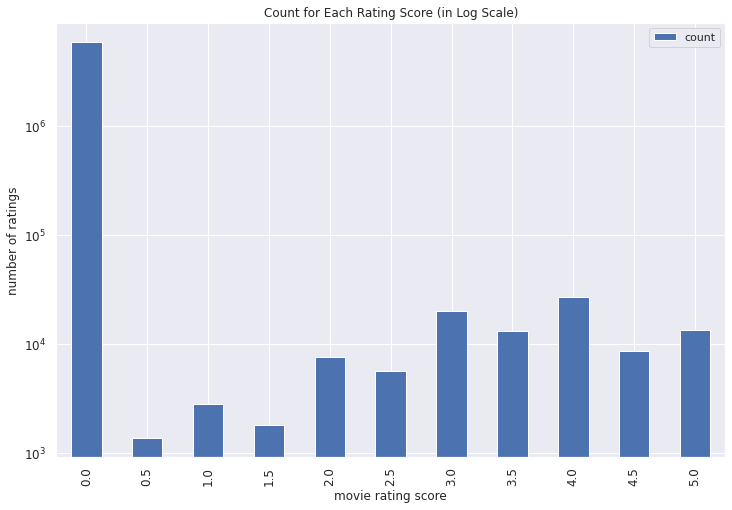

In [ ]:
ax = movie_ratings_count_update[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [ ]:
# plot rating frequency of all movies
movie_movie_count = pd.DataFrame(movie_ratings.groupby('movieId').size(), columns=['count'])
movie_movie_count.head()

,count
movieId,
1,215
2,110
3,52
4,7
5,49


Text(0, 0.5, 'number of ratings')

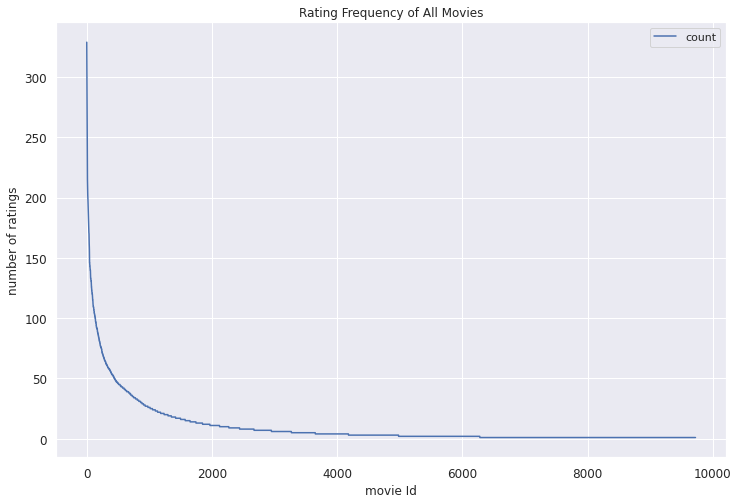

In [ ]:
# plot rating frequency of all movies
ax = movie_movie_count \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings (log scale)')

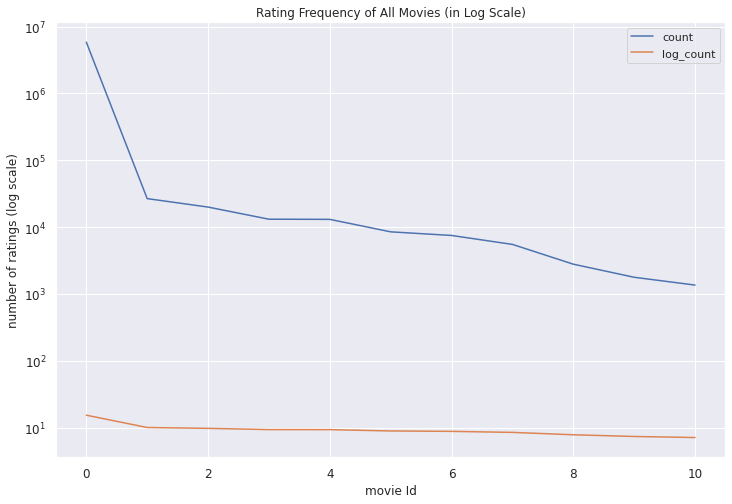

In [ ]:
# plot rating frequency of all movies in log scale
ax = movie_ratings_count_update \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

**Train Model**

**Load Data**

In [ ]:
schema = StructType([StructField("userId", IntegerType()),
                     StructField("movieId", IntegerType()),
                     StructField("rating", FloatType()),
                     StructField("timestamp", FloatType())])

In [ ]:
df = spark.read.csv('ratings.csv', header=True, schema=schema)

In [ ]:
df.show(5)

+------+-------+------+-----------+
|userId|movieId|rating|  timestamp|
+------+-------+------+-----------+
|     1|      1|   4.0|9.6498272E8|
|     1|      3|   4.0|9.6498125E8|
|     1|      6|   4.0|9.6498221E8|
|     1|     47|   5.0|9.6498381E8|
|     1|     50|   5.0|9.6498291E8|
+------+-------+------+-----------+
only showing top 5 rows



In [ ]:
schema_movies = StructType([
    StructField("movieId", IntegerType()),
    StructField("title", StringType()),
    StructField("genres", StringType())
])



In [ ]:
df_movies = spark.read.csv('movies.csv', header=True, schema=schema_movies)

In [ ]:
df_movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
schema_links = StructType([
    StructField("movieId", IntegerType()),
    StructField("imdbId", StringType()),
    StructField("tmdbId", IntegerType())
])

In [ ]:
links_df = spark.read.csv('links.csv', header=True, schema=schema_links)

In [ ]:
links_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [ ]:
training, test = df.randomSplit([0.8, 0.2])
# build ALS model with training data
# the coldStartStrategy parameter to “drop” in order to drop any rows in the DataFrame of predictions that contain NaN values. 
# The evaluation metric will then be computed over the non-NaN data and will be valid. 
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")


In [ ]:
training.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: float (nullable = true)



In [ ]:
model = als.fit(training)

In [ ]:
predictions = model.transform(test)
predictions.show(5)

+------+-------+------+------------+----------+
|userId|movieId|rating|   timestamp|prediction|
+------+-------+------+------------+----------+
|   603|    471|   4.0| 9.5448243E8| 2.6262457|
|   176|    471|   5.0| 8.4010906E8| 3.0952806|
|   448|    471|   4.0|1.17898086E9| 3.7716389|
|    32|    471|   3.0| 8.5673715E8|  3.965502|
|   541|    471|   3.0| 8.3564352E8| 3.5848877|
+------+-------+------+------------+----------+
only showing top 5 rows



In [ ]:
evaluator = RegressionEvaluator(labelCol="rating")
evaluator.evaluate(predictions)

0.8775526694428022

In [ ]:
def movie_rec(userId, numrec=5):
  
    #Get recommended movies dataframe for the specified users
    #userid : sigle user id or list of user id
    #numrec :number of recommended movies

    if type(userId) == 'int':
        userId = [userId]
    user_col = als.getUserCol()
    users_df = df.select(user_col).distinct().filter(df[user_col].isin(userId))
    rec_movie = model.recommendForUserSubset(users_df, numrec)
    users_movieIds = rec_movie.rdd.map(lambda x: [(x.userId, r.movieId) for r in x['recommendations']]).collect()                                                                                                                                                                                       
    
    rec_movie_ids = []
    for um in users_movieIds:
        rec_movie_ids.append(SQLContext(sc).createDataFrame(um, ['userId', 'movieId']))

    df_rec_movie_ids = reduce(lambda df1, df2: df1.union(df2), rec_movie_ids)
    df_rec_movies = df_rec_movie_ids.join(df_movies, 'movieId').join(links_df, 'movieId').select("userId", "movieId", "title", "imdbId")
    return df_rec_movies

In [ ]:
def display_rec_movies(userId, numrec=5):
    #display recommended movies in html

    #userid : sigle user id or list of user id

    #numrec :number of recommended movies

    rec_movies = movie_rec(userId, numrec)
    user_id =''
    for m in rec_movies.collect():
        if m.userId != user_id:
            user_id = m.userId
            display(HTML(f"<h3>Recommended movies for User ID: {user_id}</h3>"))
        display(HTML(f"<a href='https://www.imdb.com/title/tt{m.imdbId}' target='_blank'>{m.title}</a>" ))

In [ ]:
userIdInput = input("Input the user ID (single or list of ids) : ")
display_rec_movies([int(e.strip()) for e in userIdInput.split(',')])

Input the user ID (single or list of ids) : 32


In [ ]:
#ggfg